## Training Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('category_training_data.csv')

In [7]:
stop_words = list(stopwords.words("indonesian"))

In [8]:
factory = StemmerFactory()
lemmatizer = factory.create_stemmer()

In [9]:
def clean_complaint(complaint):
    # Remove usernames after '@'
    complaint = re.sub(r'@\w+', '', complaint)
    # Remove URLs
    complaint = re.sub(r'http\S+', '', complaint)
    # Remove punctuation and special symbols (commas, periods, etc.)
    complaint = re.sub(r'[^\w\s]', '', complaint)
    # Remove extra whitespace
    complaint = re.sub(r'\s+', ' ', complaint).strip()
    # Remove any zero-width characters like 'ㅤ'
    complaint = re.sub(r'[\u200B-\u200D\uFEFF\u3164]+', '', complaint)
    return complaint

In [13]:
def remove_stopwords(complaint):
    complaint = complaint.lower()
     #Tokenize and remove stop words
    words = [word for word in complaint.split() if word not in stop_words]
    # Apply lemmatization
    return words

In [14]:
def stem_complaint(complaint):
    lemmatized_words = [lemmatizer.stem(word) for word in complaint]
    return ' '.join(lemmatized_words)

In [15]:
data['cleaned_complaint'] = data['complaint'].apply(clean_complaint)

In [16]:
data['no_stopwords'] = data['cleaned_complaint'].apply(remove_stopwords)

In [17]:
data['stemmed_complaint'] = data['no_stopwords'].apply(stem_complaint)

In [21]:
data = data.drop_duplicates(subset=['complaint'])

In [20]:
data = data.dropna()

In [27]:
categories = data['category'].unique().tolist()
categories

['lingkungan',
 'fasilitas umum',
 'kekeringan',
 'polusi',
 'lainnya',
 'layanan',
 'limbah',
 'sampah',
 'hutan']

In [32]:
# Create a mapping dictionary
category_to_number = {category: index for index, category in enumerate(categories)}
# Assuming 'data' is your DataFrame and 'category' is the column
data['numbered_category'] = data['category'].map(category_to_number)

In [33]:
X = data['complaint']

In [34]:
y = data['numbered_category']

In [35]:
data.to_csv('./category_training_data.csv', index=False)

## Logistic Regression Model with Vectorizer

In [36]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

with open('logistic_regression/logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('logistic_regression/logistic_regression_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\User

Accuracy: 0.8281
Log Loss: 0.6350
F1-Score: 0.8118
Precision: 0.8158
Recall: 0.8281


C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


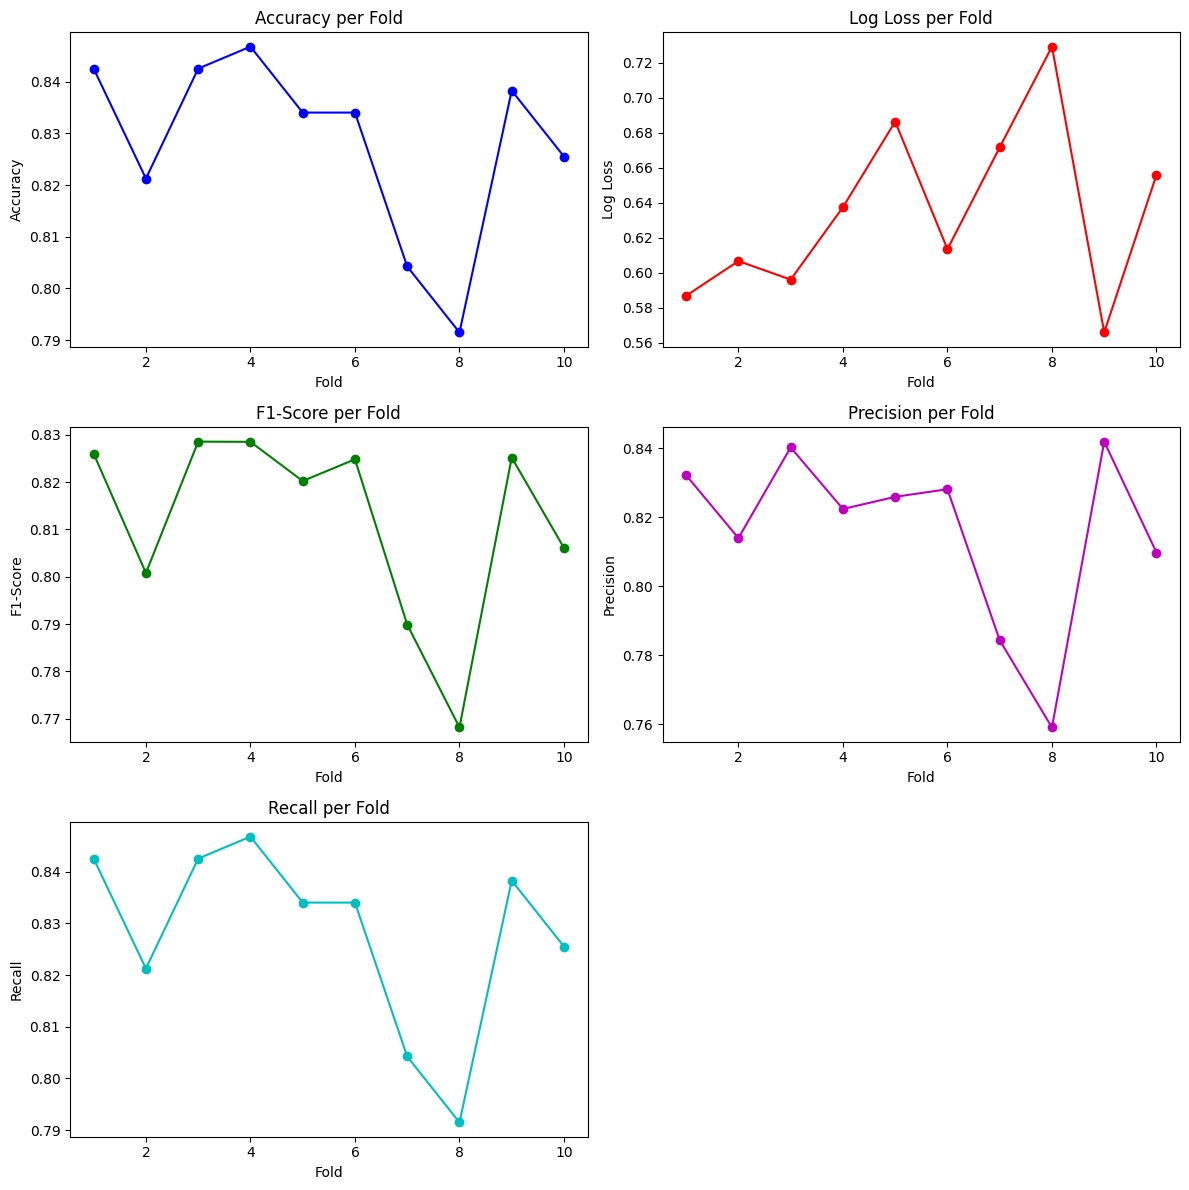


Average Accuracy: 0.8281
Average Log Loss: 0.6350
Average F1-Score: 0.8118
Average Precision: 0.8158
Average Recall: 0.8281


In [37]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Logistic Regression Model with Count Vectorizer

In [38]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer instead
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import pickle

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Use CountVectorizer for text conversion
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('logistic_regression/logistic_regression_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('logistic_regression/logistic_regression_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\User

Accuracy: 0.8711
Log Loss: 0.4620
F1-Score: 0.8677
Precision: 0.8765
Recall: 0.8711


C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


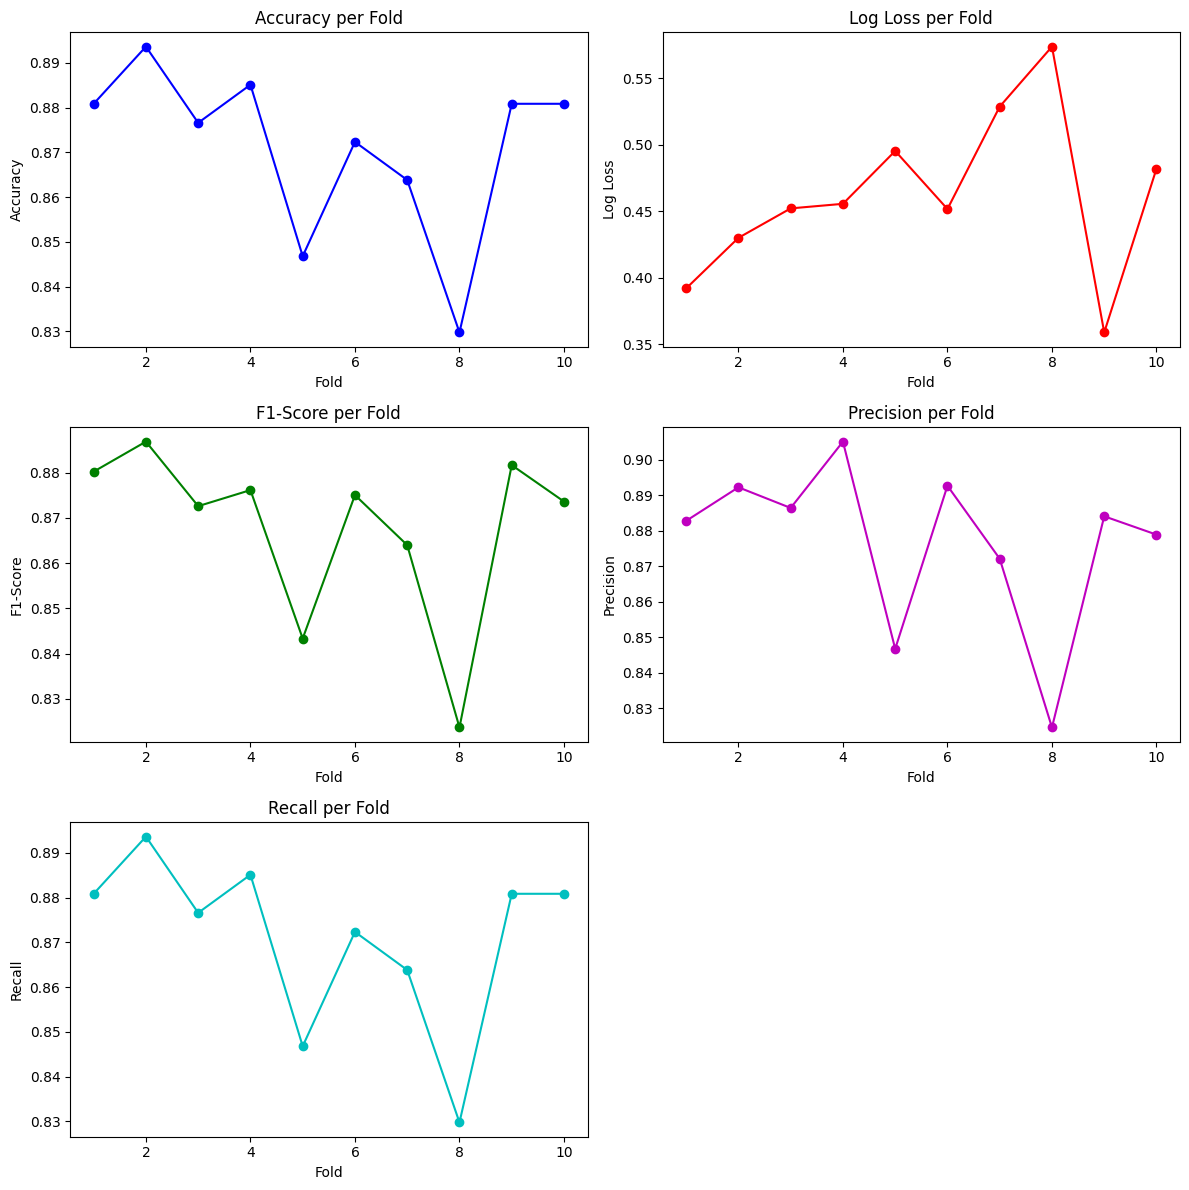


Average Accuracy: 0.8711
Average Log Loss: 0.4620
Average F1-Score: 0.8677
Average Precision: 0.8765
Average Recall: 0.8711


In [39]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## SVM Model with Vectorizer

In [ ]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = SVC(probability=True)  # Ensure SVC has probability=True for log_loss

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('svm/svm_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('svm/svm_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('svm/svm_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## SVM Model with Count Vectorizer

In [42]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Use CountVectorizer instead of TfidfVectorizer
clf = SVC(probability=True)  # Ensure SVC has probability=True for log_loss

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model and vectorizer
with open('svm/svm_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('svm/svm_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('svm/svm_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


Accuracy: 0.8230
Log Loss: 0.5354
F1-Score: 0.8062
Precision: 0.8053
Recall: 0.8230


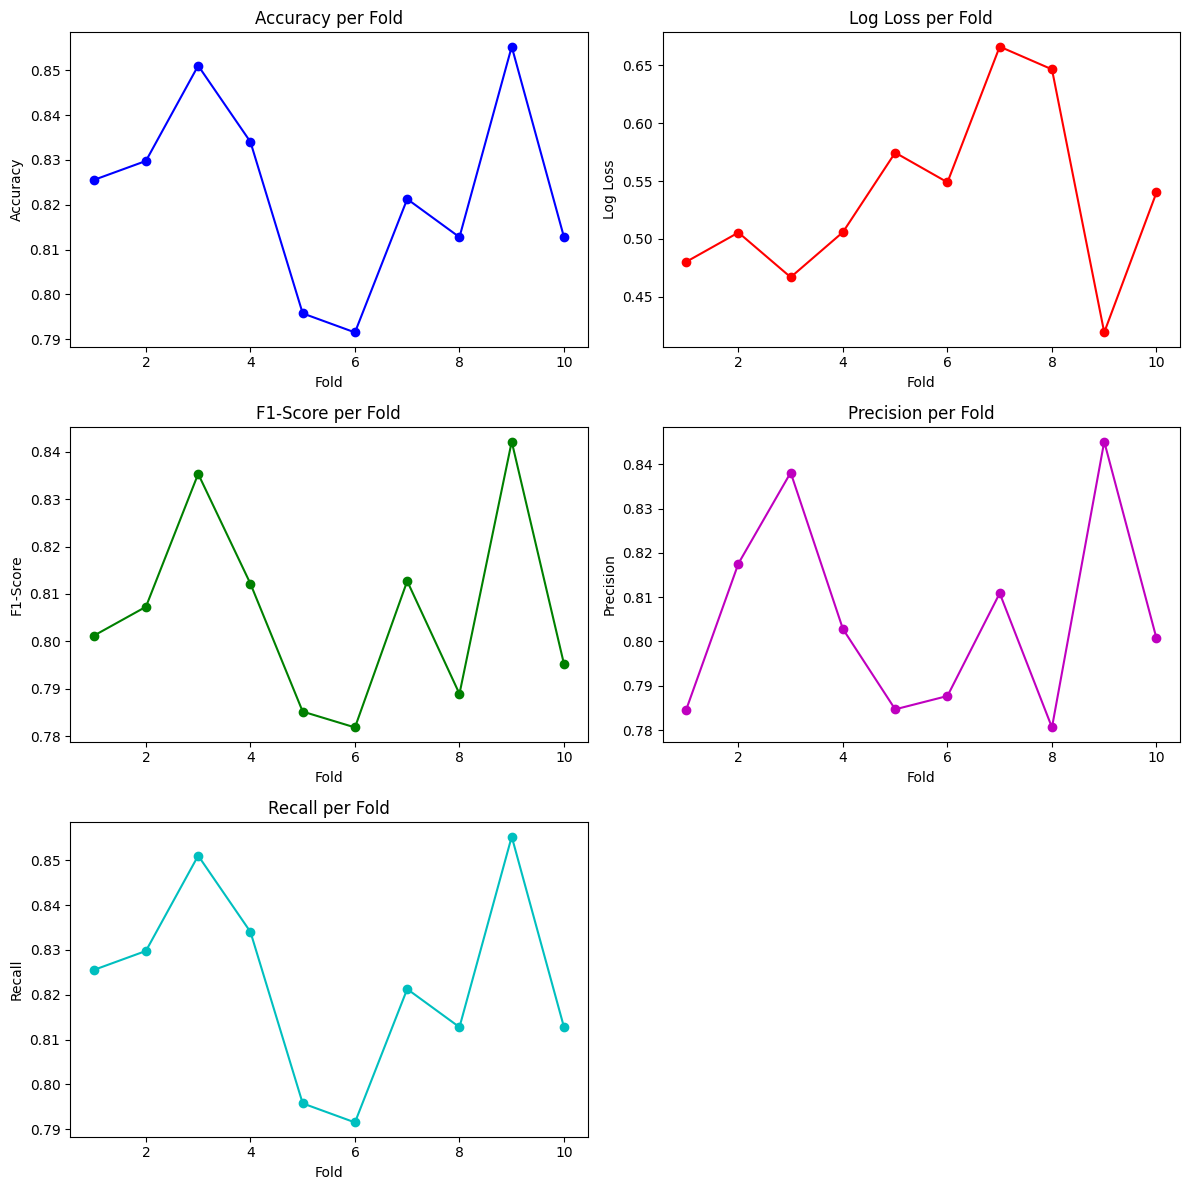


Average Accuracy: 0.8230
Average Log Loss: 0.5354
Average F1-Score: 0.8062
Average Precision: 0.8053
Average Recall: 0.8230


In [43]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Random Forest Model with Vectorizer

In [63]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Random Forest with parallel processing

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model, vectorizer, and label encoder
with open('random_forest/random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('random_forest/random_forest_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('random_forest/random_forest_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


Accuracy: 0.8911
Log Loss: 0.5060
F1-Score: 0.8831
Precision: 0.8814
Recall: 0.8911


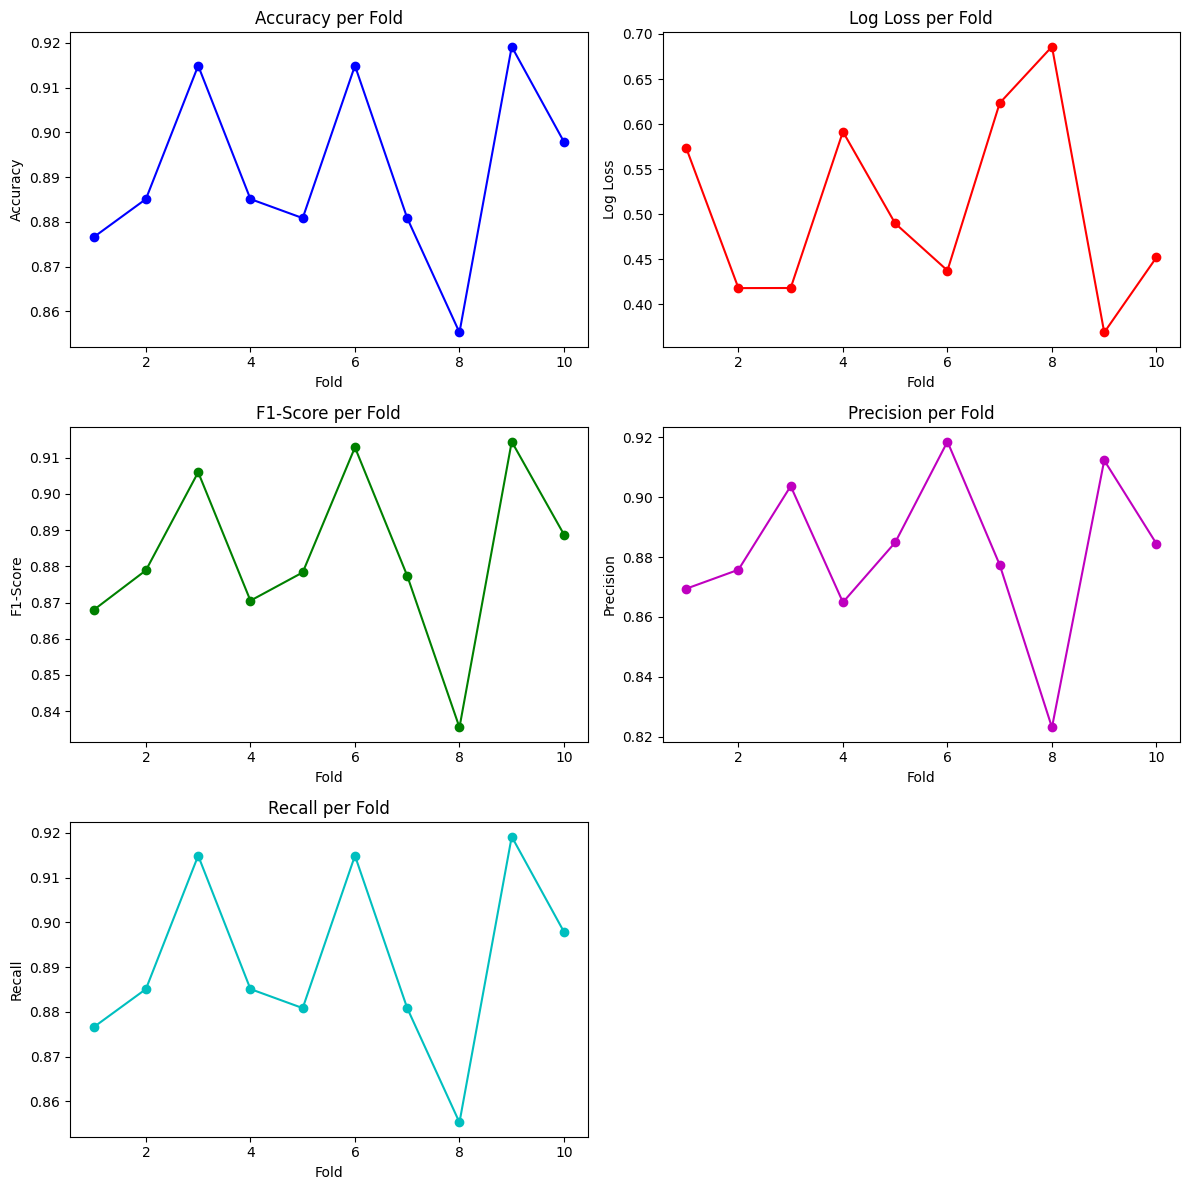


Average Accuracy: 0.8911
Average Log Loss: 0.5060
Average F1-Score: 0.8831
Average Precision: 0.8814
Average Recall: 0.8911


In [64]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Random Forestt Model with Count Vectorizer

In [61]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Convert text to numerical features using CountVectorizer
clf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Random Forest with parallel processing

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model, vectorizer, and label encoder
with open('random_forest/random_forest_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('random_forest/random_forest_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('random_forest/random_forest_cnt_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


Accuracy: 0.8940
Log Loss: 0.5159
F1-Score: 0.8877
Precision: 0.8906
Recall: 0.8940


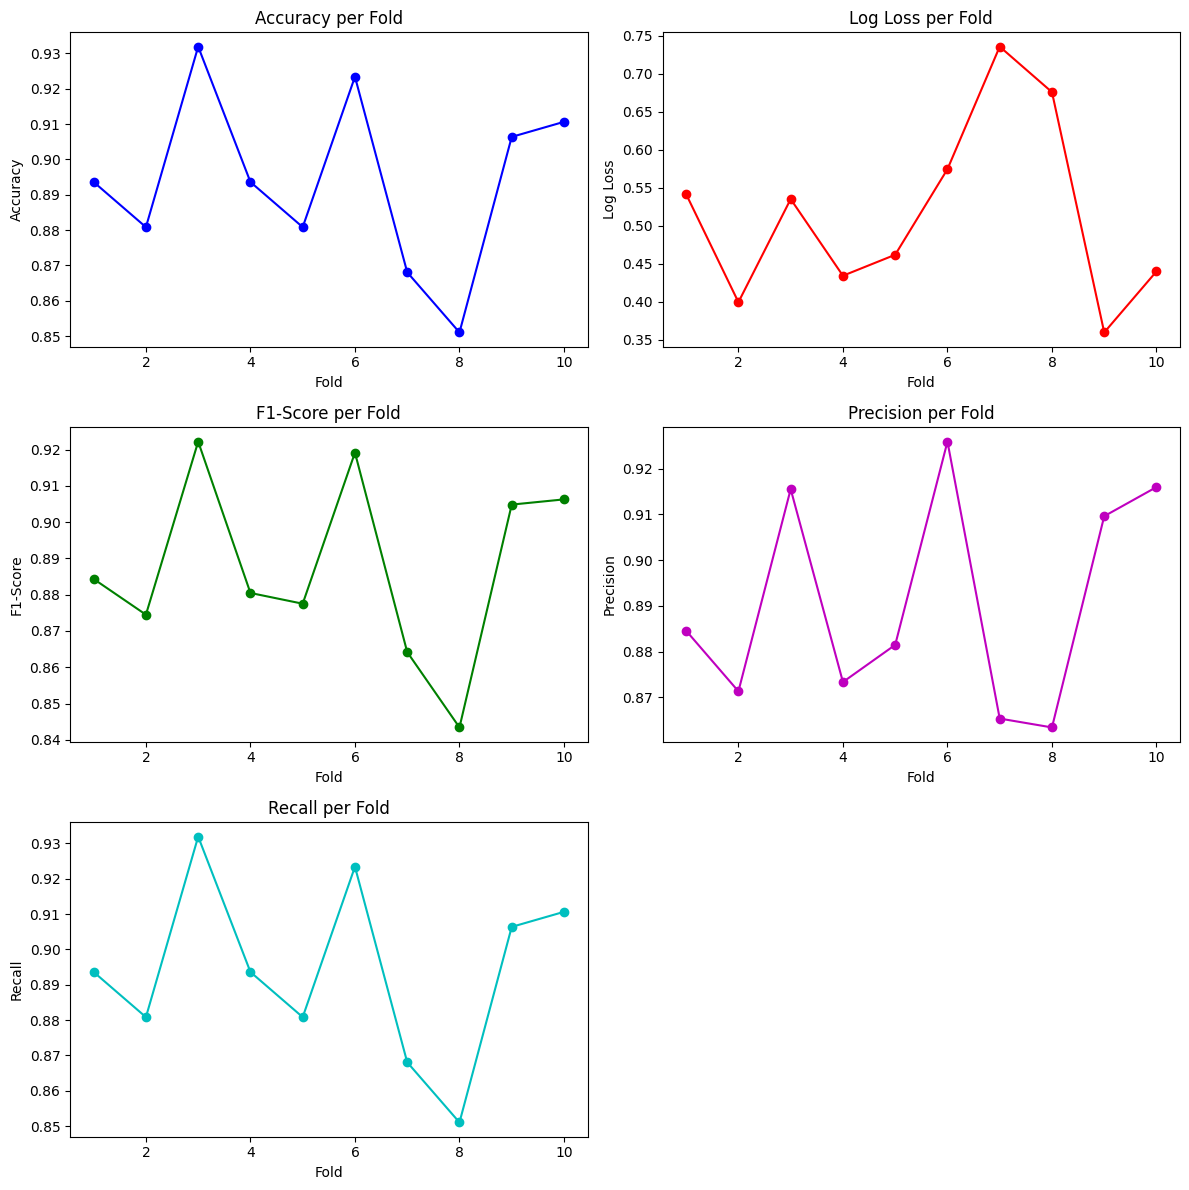


Average Accuracy: 0.8940
Average Log Loss: 0.5159
Average F1-Score: 0.8877
Average Precision: 0.8906
Average Recall: 0.8940


In [62]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Naive Bayes Model with Vectorizer

In [59]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  # Import Naive Bayes classifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features
clf = MultinomialNB()  # Using Multinomial Naive Bayes classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall with zero_division handling
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model, vectorizer, and label encoder
with open('naive_bayes/naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('naive_bayes/naive_bayes_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('naive_bayes/naive_bayes_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


Accuracy: 0.6655
Log Loss: 0.9606
F1-Score: 0.6119
Precision: 0.6228
Recall: 0.6655


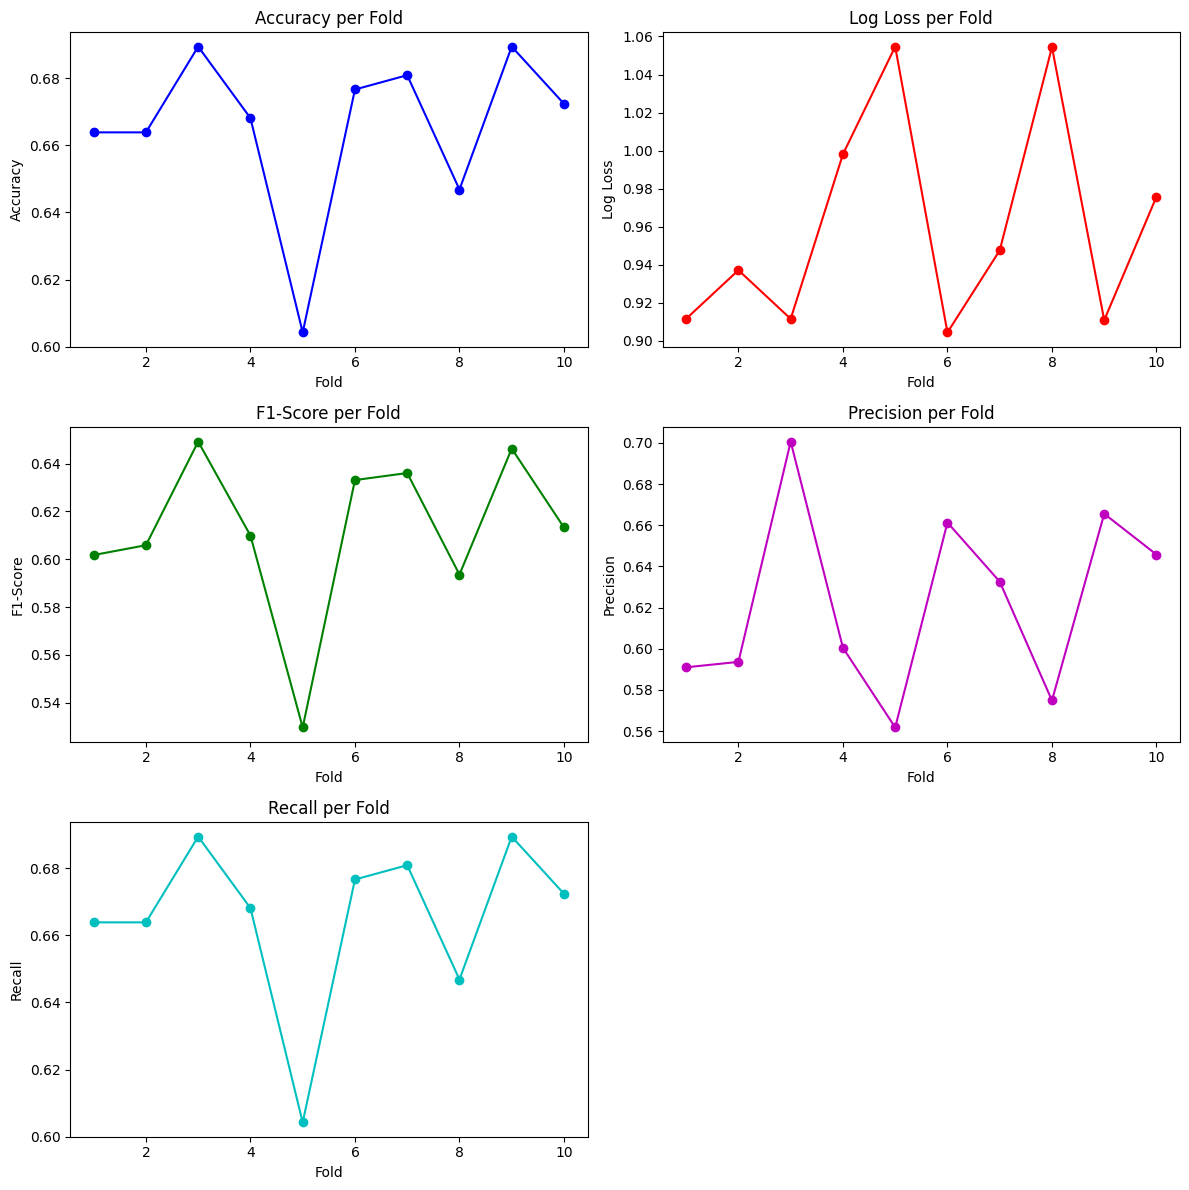


Average Accuracy: 0.6655
Average Log Loss: 0.9606
Average F1-Score: 0.6119
Average Precision: 0.6228
Average Recall: 0.6655


In [60]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Naive Bayes Model with Count Vectorizer

In [57]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer
from sklearn.naive_bayes import MultinomialNB  # Import Naive Bayes classifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize vectorizer and classifier
vectorizer = CountVectorizer(max_features=500)  # Convert text to numerical features
clf = MultinomialNB()  # Using Multinomial Naive Bayes classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall with zero_division handling
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model, vectorizer, and label encoder
with open('naive_bayes/naive_bayes_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('naive_bayes/naive_bayes_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('naive_bayes/naive_bayes_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


Accuracy: 0.7860
Log Loss: 0.9845
F1-Score: 0.7801
Precision: 0.7936
Recall: 0.7860


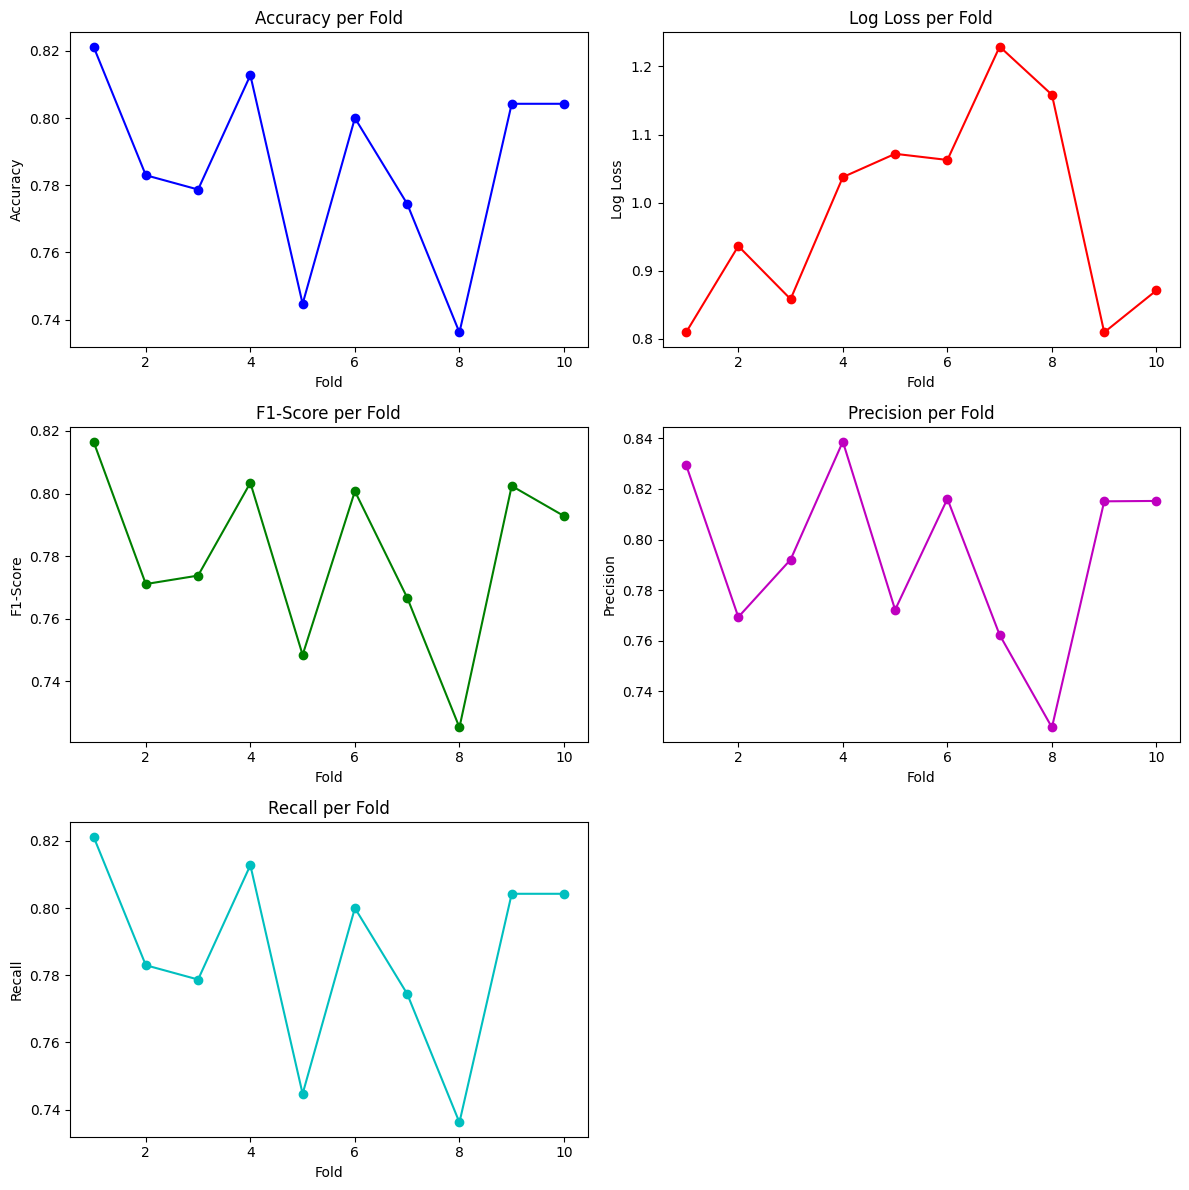


Average Accuracy: 0.7860
Average Log Loss: 0.9845
Average F1-Score: 0.7801
Average Precision: 0.7936
Average Recall: 0.7860


In [58]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## XGBoost Model with Vectorizer

In [53]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
import xgboost as xgb  # Import XGBoost
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize TfidfVectorizer and XGBoost classifier
vectorizer = TfidfVectorizer(max_features=500)  # Convert text to numerical features using TfidfVectorizer
clf = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)  # Using XGBoost classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model, vectorizer, and label encoder
with open('xgboost/xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('xgboost/xgboost_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('xgboost/xgboost_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)


C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


Accuracy: 0.8983
Log Loss: 0.4021
F1-Score: 0.8937
Precision: 0.8968
Recall: 0.8983


C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


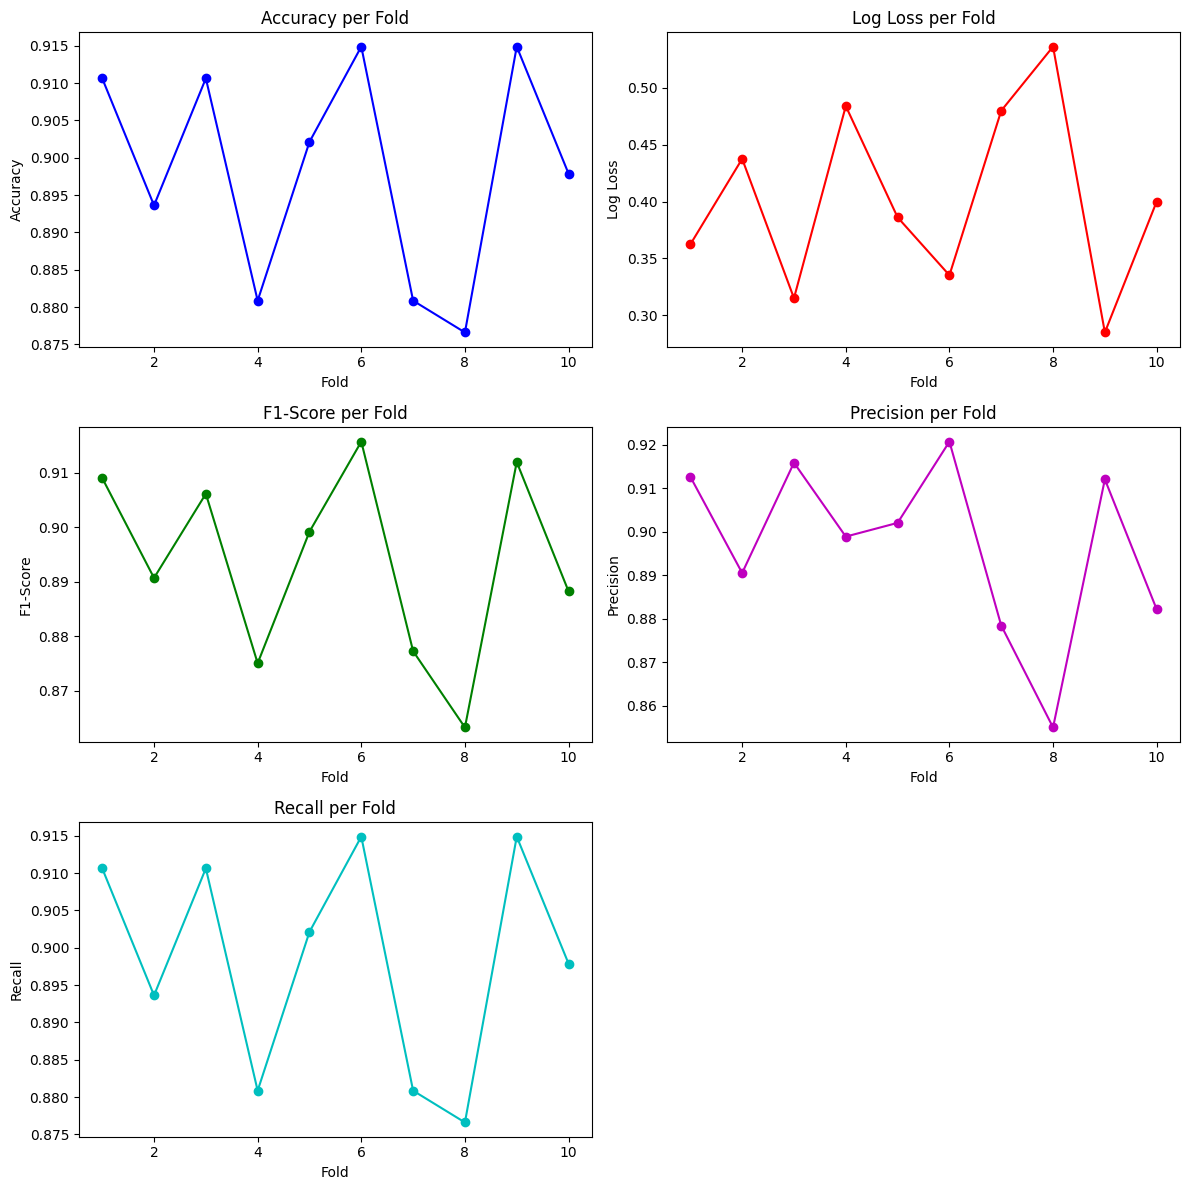


Average Accuracy: 0.8983
Average Log Loss: 0.4021
Average F1-Score: 0.8937
Average Precision: 0.8968
Average Recall: 0.8983


In [54]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## XGBoost Model with Count Vectorizer

In [55]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer  # Import TfidfVectorizer
import xgboost as xgb  # Import XGBoost
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import pickle

# Ensure that your target variable y is encoded with 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode class labels as integers (0-8 for 9 classes)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
log_losses = []
f1_scores = []
precisions = []
recalls = []

# Initialize TfidfVectorizer and XGBoost classifier
vectorizer = CountVectorizer(max_features=500)  # Convert text to numerical features using TfidfVectorizer
clf = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)  # Using XGBoost classifier

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Train the vectorizer on the training data (fit on X_train)
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Train the classifier on the transformed training data
    clf.fit(X_train_vec, y_train)

    # Transform the test data using the fitted vectorizer (do not fit again)
    X_test_vec = vectorizer.transform(X_test)
    
    # Make predictions
    y_pred = clf.predict(X_test_vec)
    y_pred_proba = clf.predict_proba(X_test_vec)  # Probabilities for log loss
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    # Calculate log loss
    loss = log_loss(y_test, y_pred_proba)
    log_losses.append(loss)
    
    # Calculate F1-score, precision, and recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Print average metrics across all folds
print(f"Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Recall: {sum(recalls)/len(recalls):.4f}")

# Save the model, vectorizer, and label encoder
with open('xgboost/xgboost_cnt_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('xgboost/xgboost_cnt_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save label encoder to map predicted values back to labels
with open('xgboost/xgboost_label_encoder.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\thori\OneDrive\Documents\Program\Bangkit\Gedor\ml\capstone\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 


Accuracy: 0.9094
Log Loss: 0.3638
F1-Score: 0.9061
Precision: 0.9107
Recall: 0.9094


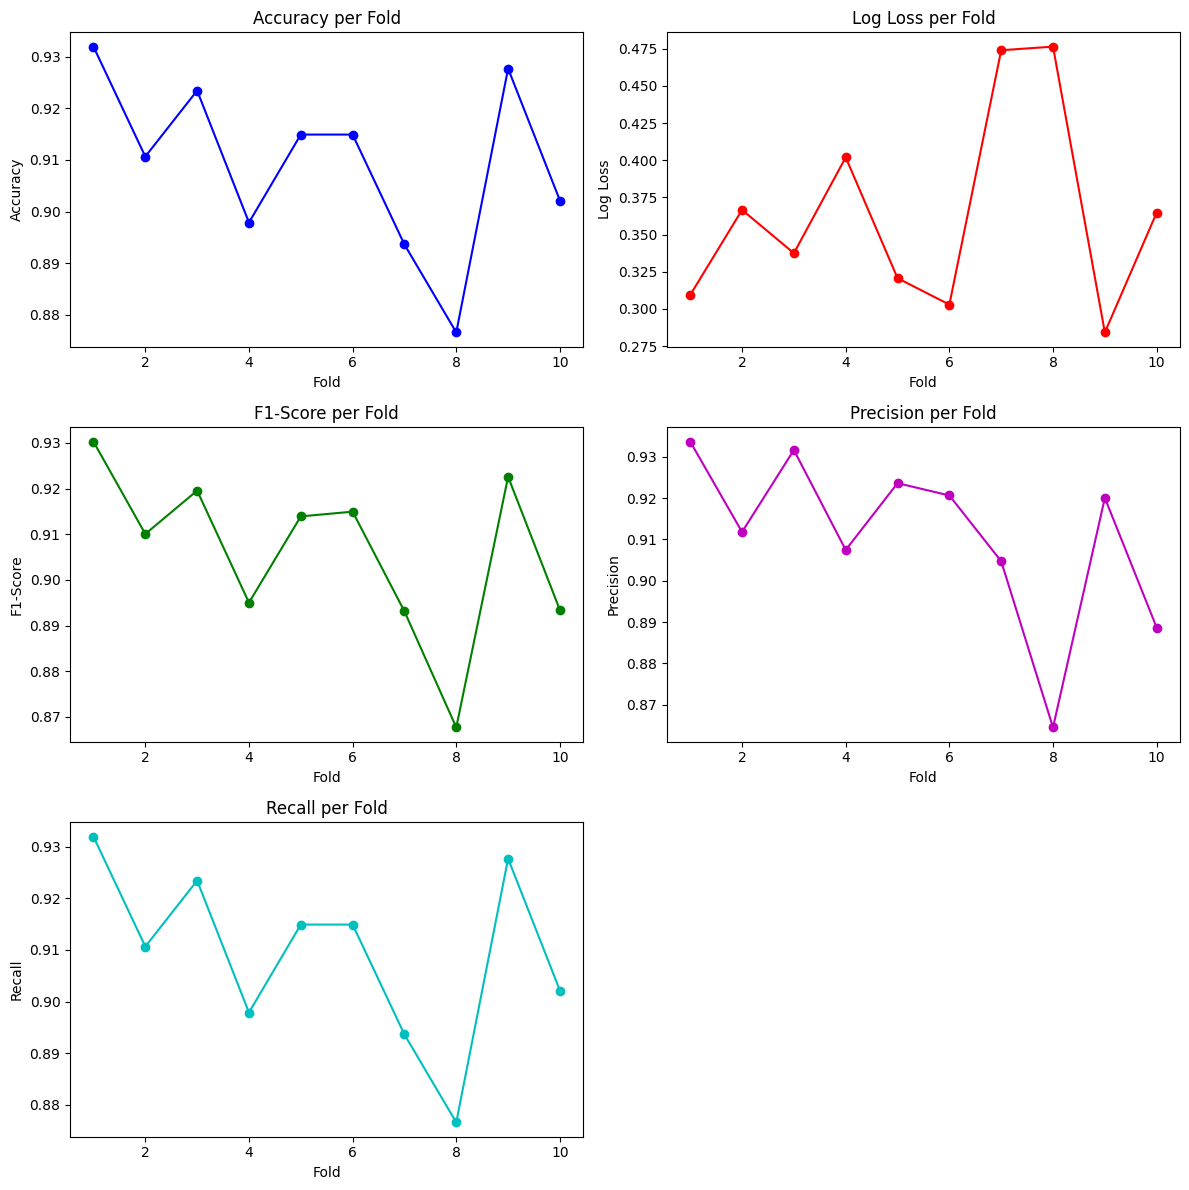


Average Accuracy: 0.9094
Average Log Loss: 0.3638
Average F1-Score: 0.9061
Average Precision: 0.9107
Average Recall: 0.9094


In [56]:
import matplotlib.pyplot as plt

# Plot the metrics for each fold
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(range(1, kf.get_n_splits() + 1), accuracies, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Accuracy per Fold")
axes[0, 0].set_xlabel("Fold")
axes[0, 0].set_ylabel("Accuracy")

# Log Loss plot
axes[0, 1].plot(range(1, kf.get_n_splits() + 1), log_losses, marker='o', linestyle='-', color='r')
axes[0, 1].set_title("Log Loss per Fold")
axes[0, 1].set_xlabel("Fold")
axes[0, 1].set_ylabel("Log Loss")

# F1-Score plot
axes[1, 0].plot(range(1, kf.get_n_splits() + 1), f1_scores, marker='o', linestyle='-', color='g')
axes[1, 0].set_title("F1-Score per Fold")
axes[1, 0].set_xlabel("Fold")
axes[1, 0].set_ylabel("F1-Score")

# Precision plot
axes[1, 1].plot(range(1, kf.get_n_splits() + 1), precisions, marker='o', linestyle='-', color='m')
axes[1, 1].set_title("Precision per Fold")
axes[1, 1].set_xlabel("Fold")
axes[1, 1].set_ylabel("Precision")

# Recall plot
axes[2, 0].plot(range(1, kf.get_n_splits() + 1), recalls, marker='o', linestyle='-', color='c')
axes[2, 0].set_title("Recall per Fold")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("Recall")

# Hide empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Print average metrics across all folds
print(f"\nAverage Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Log Loss: {sum(log_losses)/len(log_losses):.4f}")
print(f"Average F1-Score: {sum(f1_scores)/len(f1_scores):.4f}")
print(f"Average Precision: {sum(precisions)/len(precisions):.4f}")
print(f"Average Recall: {sum(recalls)/len(recalls):.4f}")

## Bidirectional LSTM